# 第9回: RNN: Exercise1
## Echo State Networksで神経活動を学習する
### 概要
本演習ではpythonを用いてEcho State Networksを実装します。

学習データセットとして、運動イメージの脳波データを用い、与えられた脳波から2つの運動イメージをデコードします。

まず、講師が概要を説明しますので、全体を掴んだところで演習に取り組んでください。

### 目標
- numpyでESNを実装する
- 神経活動を記録したデータ・セットを学習する
    - EEGから運動イメージを予測する

In [0]:
# Install Requrements
!pip install mne

In [0]:
# Import required modules
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import mne
import pickle
from mne.decoding import CSP

使用するEEGデータセットをロードします．(稀にタイムアウトしますが，その場合は再度試してみてください)

In [0]:
# Load EEG data
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
# runs = [6, 10, 14]  # Sessions to download
runs = [6, 10, 14]  # Sessions to download
raw_fnames = mne.datasets.eegbci.load_data(subject, runs)
raw_files = [
    mne.io.read_raw_edf(f, preload=True, stim_channel='auto')\
    for f in raw_fnames
]
raw = mne.io.concatenate_raws(raw_files)

# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

# read events
events = mne.find_events(raw, stim_channel='STI 014')

# pick only EEG channels in datasets
# dropping bad channels
picks = mne.pick_types(
    raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads'
)

epochs = mne.Epochs(
    raw, events, event_id, tmin, tmax,
    proj=True, picks=picks, baseline=None, preload=True
)
# epochs_data = epochs.get_data()
# epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
epochs_data_raw = epochs.get_data()
epochs_data = epochs.copy().crop(tmin=1., tmax=2.).get_data()
evoked = epochs.average()

Extracting edf Parameters from /content/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /content/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /content/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Setting up band-pass filter from 7 - 30 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 265 samples (1.656 sec) selected
Setting up band-pass filter from 7 - 30 Hz
l_trans_ban

学習データセットを分割します．

In [0]:
n_train = 40
data_train = epochs_data[:n_train]
data_test = epochs_data[n_train:]
labels = epochs.events[:, -1] - 2
train_labels = labels[:n_train]
test_labels = labels[n_train:]
print('Shape of the dataset. train:{}, test:{}'.format(data_train.shape, data_test.shape))

Shape of the dataset. train:(40, 64, 161), test:(5, 64, 161)


EEGをそのまま処理することは難しいので，CSP (Common Spatial Pattern)を使って特徴抽出を行います．
※ CSPについては，[references](https://drive.google.com/file/d/10tTdNvn3qUq7aFMCjEdhtLLJ7XzYeGKD/view?usp=sharing)を参照．

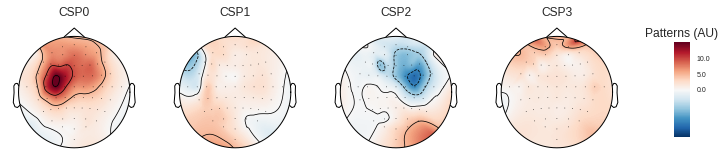

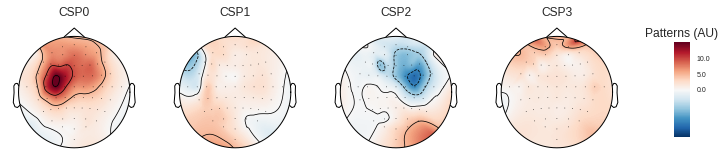

In [0]:
# creates CSP feature extractor
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data_raw, labels)

layout = mne.channels.read_layout('EEG1005')
csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg',
                  units='Patterns (AU)', size=1.5)

In [0]:
sfreq = raw.info['sfreq']
w_length = 20  # running classifier: window length
w_step = 10  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

In [0]:
print(w_length, w_step, w_start)

20 10 [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140]


In [0]:
def feature_extractor(x_in):
  X = []
  for n in w_start:
    # datas, channels, lengths
    data = x_in[:, :, n:(n + w_length)]
    X.append(csp.transform(data))

  X = np.array(X).transpose((1, 2, 0))
  return X

X_train = feature_extractor(data_train)
X_test = feature_extractor(data_test)
print('(datas, channels, length)', X_train.shape, X_test.shape)

(datas, channels, length) (40, 4, 15) (5, 4, 15)


In [0]:
train_data_0 = []
train_data_1 = []
for i, c in enumerate(train_labels):
  if c == 0:
    train_data_0 += [X_train[i]]
  else:
    train_data_1 += [X_train[i]]
train_data_0 = np.array(train_data_0)
train_data_1 = np.array(train_data_1)
print(train_data_0.shape, train_data_1.shape)

(19, 4, 15) (21, 4, 15)


In [0]:
test_data_0 = []
test_data_1 = []
for i, c in enumerate(test_labels):
  if c == 0:
    test_data_0 += [X_test[i]]
  else:
    test_data_1 += [X_test[i]]
test_data_0 = np.array(test_data_0)
test_data_1 = np.array(test_data_1)
print(test_data_0.shape, test_data_1.shape)

(2, 4, 15) (3, 4, 15)


## ESNの実装
では，実際にESNの実装をしてみましょう．
### ハイパーパラメータの設定
以下ではハイパーパラメータの設定を行います。
- 入力: `Nu`
- 出力: `Ny`
- 隠れ素子: `Nx`
- leaking rate: `a`

In [0]:
# set hyper params
train_data = train_data_0
init_len = 5
Nu = train_data.shape[1]  # Nu
Ny = train_data.shape[1]  # Ny
Nx = 500  # Nx
Nt = train_data.shape[2] - init_len
Nb = train_data.shape[0]
a = 0.3 # leaking rate
print('Nu:{}, Nx:{}, Ny:{}, Nt:{}, Nb:{}'.format(Nu, Nx, Ny, Nt, Nb))

Nu:4, Nx:500, Ny:4, Nt:10, Nb:19


### Variableの設定
ESNで使用するパラメータは，入力重み`Win`，reservoir重み`W`，出力重み`Wout`の３つです．

この内学習するのは出力重みだけでしたね．

次元に気をつけて，パラメータの設定を行います。

In [0]:
np.random.seed(46)
# input weights
# Win: (Nx, 1 + Nu) bias included
Win = (np.random.rand("*** YOUR CODE HERE ***") - 0.5) * 1

# reservoir weights
# W: (Nx, Nx)
W = np.random.rand("*** YOUR CODE HERE ***") - 0.5 
# rhoW = max(abs(np.linalg.eig(W)[0]))
# print(rhoW)
# rhoW = 13.1516
# W *= 18.25 / rhoW
W *= 0.8 # Magic!

# output weights (a placeholder)
# Wout: (Ny, 1 + Nx + Nu)
Wout = np.zeros("*** YOUR CODE HERE ***")

# allocated memory for the design (collected states) matrix
# X: (1 + Nu + Nx, Nb, Nt)
X = np.zeros("*** YOUR CODE HERE ***")

# set the corresponding target matrix directly
Yt = train_data.T[init_len:, :, :n_train]

x = np.zeros("*** YOUR CODE HERE ***")

ones = np.ones(Nb).reshape((-1, 1)).T

各パラメータの`shape`は以下のようになります

In [0]:
print('Win:{}, W:{}, X:{}, Yt:{}, x:{}'.format(
    Win.shape, W.shape, X.shape, Yt.shape, x.shape))

Win:(500, 5), W:(500, 500), X:(10, 505, 19), Yt:(10, 4, 19), x:(500, 1)


データを表現する際にはたとえ一次元であっても、列ベクトルで表記するべきです。

すなわち、ベクトルのshapeは(25,)ではなく(25, 1)として計算することを心がけてください。

### Forwarding
データをネットワークにfeedします．この時，ネットワークのreservoir層を活動を安定化させるため，初期化を行います．

In [0]:
for t, un in enumerate(train_data.T):
    # (Nx, Nb) = (Nx, Nu + 1)(Nu + 1, Nb) + (Nx, Nx)(Nx, Nb)
    x_tld = "*** YOUR CODE HERE ***"
    x = "*** YOUR CODE HERE ***"
    if t >= init_len:
        X[t - init_len, :, :] = np.vstack("*** YOUR CODE HERE ***")
print(X.shape)

(10, 505, 19)


#### Hint
・行列同士の積は`np.dot()`を使用しましょう
```python
# EXAMPLE
>>> a = [[1, 0], [0, 1]]
>>> b = [[4, 1], [2, 2]]
>>> np.dot(a, b)
array([[4, 1],
       [2, 2]])
```

・reservoir層の活性化関数には`np.tanh()`を使用しましょう


・行列を垂直方向に重ねるには`numpy.vstack()`が便利です
```python
# EXAMPLE
>>> a = np.array([1, 2, 3])
>>> b = np.array([2, 3, 4])
>>> np.vstack((a,b))
array([[1, 2, 3],
       [2, 3, 4]])
       
>>> np.vstack((0, [[1], [2], [3]]))
array([[0],
       [1],
       [2],
       [3]])
```

In [0]:
print(Yt.shape, X.shape)

(10, 4, 19) (10, 505, 19)


In [0]:
X_mat = X.transpose((1, 0, 2)).reshape((X.shape[1], -1))
Yt_mat = Yt.transpose((1, 0, 2)).reshape((Yt.shape[1], -1))
print(X_mat.shape, Yt_mat.shape)

(505, 190) (4, 190)


`np.reshape`関数の挙動には注意しましょう．変換後の形が一緒だからといって，内容が一致しているとは限りません．(see [docs](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html))

In [0]:
_X_mat = X.reshape((X.shape[1], -1))

In [0]:
print('{}\n{}'.format(list(_X_mat[5, :3]), list(X_mat[5, :3])))

[-0.7894231546280588, -0.7663345128575269, -0.7764500723666579]
[0.6755199700398087, 0.0930913329490163, -0.31497573860904005]


### Training
`X_mean`を用いて学習を行います．出力重み行列`Wout`を求めるには，擬似逆行列を用いるか，最小二乗法を用いる方法があります．

疑似逆行列の計算は`np.liniag.pinv()`を使いましょう．

In [0]:
# using pseudo inverse matrix
# Wout: (Ny, 1 + Nu + Nx)
# Wout = np.dot(Yt_mat, np.linalg.pinv(X_mat))

以下は，リッジ回帰の実装です．(両方試してみましょう)

In [0]:
# For regression
reg = 1e-8  # regularization coefficient
X_T = X_mat.T
Wout = np.dot(
    np.dot(Yt_mat, X_mat.T),
    np.linalg.inv(np.dot(X_mat, X_T) + reg * np.eye(1 + Nu +  Nx))
)

### Evaluation
以下では評価計算を行います。
実装はForwardingの部分と殆ど同じです。

In [0]:
# clear resv states
test_data = test_data_0
test_batch_size = test_data.shape[0]
x = np.zeros((Nx, 1))
X = np.zeros((Nt, 1 + Nu + Nx, test_batch_size))
Y = np.zeros((Nt, Ny, test_batch_size))
Yt = test_data.T[init_len: , :n_train, :]
# set the corresponding target matrix directly

ones = np.ones(test_batch_size).reshape((-1, 1)).T

In [0]:
generate = False
for t, un in enumerate(test_data.T):
    # (Nx, Nb) = (Nx, Nu + 1)(Nu + 1, Nb) + (Nx, Nx)(Nx, Nb)
    if t >= init_len + 1 and generate:
        un = y_hat
    x_tld = "*** YOUR CODE HERE ***"
    x = "*** YOUR CODE HERE ***"
    if t >= init_len:
        Xk = np.vstack((ones, un, x))
        X[t - init_len, :, :] = Xk
        y_hat = np.dot(Wout, Xk)
        Y[t - init_len, :, :] = y_hat

In [0]:
print('(Length, Channels, Samples)', Y.shape, Yt.shape)
mse = np.mean(np.sum((Y - Yt)**2, axis=2), axis=1)
print(np.mean(mse))

(Length, Channels, Samples) (10, 4, 2) (10, 4, 2)
0.0037502449077370255


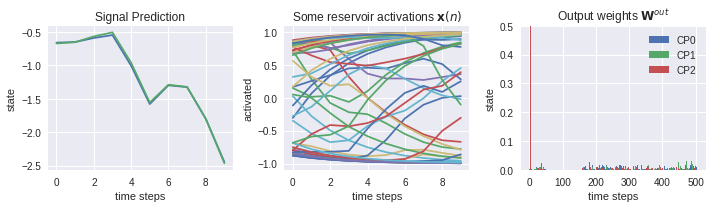

In [0]:
fig1 = plt.figure(figsize=(10, 3))
x = range(len(Y[:, 0, 0]))
ax = fig1.add_subplot(131)
ax.set_xlabel('time steps')
ax.set_ylabel('state')
ax.plot(x, Yt[:, 1, 0], label='teacher')
ax.plot(x, Y[:, 1, 0], label='predicted')
ax.set_title('Signal Prediction')


x = range(len(X[:, 0, 0]))
bx = fig1.add_subplot(132)
bx.set_xlabel('time steps')
bx.set_ylabel('activated')
rand_idx = np.random.choice(X.shape[1], 50, replace=False)
bx.plot(x, X[:, rand_idx, 1])
bx.set_title('Some reservoir activations $\mathbf{x}(n)$')

x = range(1 + Nu + Nx)
cx = fig1.add_subplot(133)
cx.set_xlabel('index')
cx.set_ylabel('value')
cx.bar(x, Wout[0].T, label='CP0')
cx.bar(x, Wout[1].T, label='CP1')
cx.bar(x, Wout[2].T, label='CP2')
cx.set_title('Output weights $\mathbf{W}^{out}$')
cx.set_ylim((0, 0.5))

plt.tight_layout()
plt.legend()
plt.show()

## ESN Classの実装

ESNのクラスを実装します．

In [0]:
 class ESN():
  def __init__(self, Nu, Ny, Nx=1000, a=0.3, seed=46):
    self.Nu = Nu  # size of input
    self.Nx = Nx  # size of reservoir
    self.Ny = Ny  # size of output
    self.a = a  # leaking rate
    np.random.seed(seed)
    
    self.Win = None
    self.W = None
    self.Wout = None
    
    # reservoir placeholer
    self.x = np.zeros((Nx, 1))
    self._initialize_weights()
    
  def __call__(self, un):
    '''
    ARGS:
      un (array): (CHANNEL SIZE, BATCH SIZE)
    RETURNS:
      Yhatk (array): (Ny, BATCH SIZE)
      Xk (array): (1 + Nu + Nx, BATCH SIZE)
    '''
    ones = np.ones(un.shape[-1]).reshape((-1, 1)).T
    # (Nx, Nb) = (Nx, Nu + 1)(Nu + 1, Nb) + (Nx, Nx)(Nx, Nb)
    x_tld = np.tanh(
        "*** YOUR CODE HERE ***"
    )
    self.x = "*** YOUR CODE HERE ***"  # update resv
    Xk = np.vstack((ones, un, self.x))
    Yhatk = np.dot(self.Wout, Xk)
    return Yhatk, Xk
  
  def train(self, X_mat, Yt_mat):
    print('input shape: X_mat{}, Yt_mat{}\ntraining...'.format(
      X_mat.shape, Yt_mat.shape
    ))
    # train with inv or regression
    self.Wout = np.dot(Yt_mat, np.linalg.pinv(X_mat))
    
  def _initialize_weights(self):
    # input weights (initialized random)
    # Win: (Nx, 1 + Nu) bias included
    self.Win = (np.random.rand("*** YOUR CODE HERE ***") - 0.5) * 1
    
    # reservoir weights
    # W: (Nx, Nx)
    self.W = np.random.rand("*** YOUR CODE HERE ***") - 0.5
    self.W *= 0.299  # Magic!
    
    # output weights (a place holder)
    self.Wout = np.zeros("*** YOUR CODE HERE ***")
    
  def clearresv(self):
    # clear reservoir status
    self.x = np.zeros((self.Nx, 1))

インスタンスを生成します．esn0がclass0の予測を，esn1がclass1の予測を担当します．

In [0]:
esn0 = ESN(Nu, Ny)
esn1 = ESN(Nu, Ny)

In [0]:
def compute_X(esn, inpts, init_len=50):
  # inpts: (length, channel, batch)
  esn.clearresv()
  Nb = inpts.shape[-1]
  Nt = inpts.shape[0]
  X = np.zeros((Nt - init_len, 1 + esn.Nu + esn.Nx, Nb))
  for t, un in enumerate(inpts):
    _, Xk = esn(un)
    if t >= init_len:
      X[t - init_len, :, :] = Xk
  return X

### Forwarding

In [0]:
X0 = compute_X(esn0, train_data_0.T, init_len)
X1 = compute_X(esn1, train_data_1.T, init_len)
X0_mat = X0.reshape((X0.shape[1], -1))  # reshape into (channel, length x batch)
X1_mat = X1.reshape((X1.shape[1], -1))

Yt0 = train_data_0.T[:X0.shape[0]]  # Yt should have the same length as X
Yt1 = train_data_1.T[:X1.shape[0]]
Yt0_mat = Yt0.reshape((Yt0.shape[1], -1))  # reshape into (channel, length x batch)
Yt1_mat = Yt1.reshape((Yt1.shape[1], -1))
print(X0.shape ,X0_mat.shape, Yt0_mat.shape)

(10, 1005, 19) (1005, 190) (4, 190)


### Training

In [0]:
# train networks
esn0.train(X0_mat, Yt0_mat)
esn1.train(X1_mat, Yt1_mat)

input shape: X_mat(1005, 190), Yt_mat(4, 190)
training...
input shape: X_mat(1005, 210), Yt_mat(4, 210)
training...


### Evaluation

In [0]:
def compute_Y(esn, inpts, init_len=50, generate=False):
  # inpts: (length, channel, batch)
  esn.clearresv()
  Nb = inpts.shape[-1]
  Nt = inpts.shape[0]
  Y = np.zeros((Nt - init_len, esn.Ny, Nb))
  for t, un in enumerate(inpts):
    if t >= init_len + 1 and generate:
      un = Yhatk
    Yhatk, Xk = esn(un)
    if t >= init_len:
      Y[t - init_len, :, :] = Yhatk
  return Y

In [0]:
Y0 = compute_Y(esn0, X_test.T, init_len)
Y1 = compute_Y(esn1, X_test.T, init_len)
Yt = X_test.T[init_len:]

In [0]:
print(Y0.shape, Yt.shape)

(10, 4, 5) (10, 4, 5)


In [0]:
mse0 = np.mean(np.sum((Y0 - Yt)**2, axis=1), axis=0)
mse1 = np.mean(np.sum((Y1 - Yt)**2, axis=1), axis=0)

In [0]:
results = []
for v0, v1 in zip(mse0, mse1):
  results += [0] if v0 > v1 else [1]

In [0]:
print('Predicted:   {}\nGround Truth:{}'.format(results, list(test_labels)))

Predicted:   [1, 1, 0, 0, 1]
Ground Truth:[1, 0, 1, 0, 1]
